In [3]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import cartopy.crs as ccrs
import netCDF4 as nc
#import matplotlib.ticker as mticker
#import warnings; warnings.filterwarnings('ignore')
import cmocean
#from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
#from eofs.standard import Eof

from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

import scipy as sp
from scipy import interpolate
from scipy import signal
from scipy.interpolate import griddata


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Reading in coarse velocity data that I previously saved

In [4]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs = xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t'][::10,::10]; lat=fs['geolat_t'][::10,::10]
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_c']/360 *2*np.pi);

%cd /work/eay/
u_full = xr.open_dataset('u_1year_CM2.6.nc')['u_full']
v_full = xr.open_dataset('v_1year_CM2.6.nc')['v_full']
zl = v_full.st_ocean

%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history
time = xr.open_dataset('02010101.ocean_minibling_field_u.nc')['time'] #,'02020101.ocean_minibling_field_u.nc'
print('done')


/net2/smg/documents/OMDT/analysis_CM2p6/grids
/work2/eay
/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history


/nbhome/eay/anaconda3/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


done


In [5]:
u_eddy = u_full - u_full.mean('time')
v_eddy = v_full - v_full.mean('time')

In [6]:
u_eddy_sn = np.abs(u_eddy[-1,:])
v_eddy_sn = np.abs(v_eddy[-1,:])

print(u_eddy_sn.shape, v_eddy_sn.shape)

(50, 270, 360) (50, 270, 360)


In [7]:
# #Reshape into a 2D array and normalize:
# u_eddy_n = np.array(u_eddy_sn).reshape(50,270*360)
# u_eddy_n = np.nan_to_num(u_eddy_n,0)
# u_eddy_norm = preprocessing.normalize(u_eddy_n,norm='l2')

v_eddy_n = np.array(v_eddy_sn).reshape(50,270*360)
v_eddy_n = np.nan_to_num(v_eddy_n,0)
v_eddy_norm = preprocessing.normalize(v_eddy_n,norm='l2')

# flatten spectra_norm 
#spectra_norm_flat[i_file,:] = spectra_norm[i_file,:,:].flatten()

In [8]:
v_eddy_norm.shape

(50, 97200)

In [20]:
v_eddy_n[:,3000]

array([0.03495613, 0.0287406 , 0.02703084, 0.02654422, 0.02605295,
       0.02484003, 0.02327546, 0.02114829, 0.01869396, 0.01620194,
       0.01362061, 0.0113459 , 0.0100918 , 0.01008822, 0.01065703,
       0.01099739, 0.01081012, 0.00972007, 0.00316543, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [21]:
v_eddy_norm[:,3000]

array([0.00138459, 0.00116312, 0.00110868, 0.00110588, 0.00111258,
       0.00108256, 0.0010338 , 0.00096138, 0.00087018, 0.00076954,
       0.00065945, 0.00056076, 0.00050891, 0.00051874, 0.00055913,
       0.00058899, 0.00059154, 0.00054423, 0.00018191, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [16]:
            
############# PCA ################
        
# PCA on total spectra flattened array
pca = PCA(0.95)  #pca that accounts for 95% of the data; alternatively say number of PCs
lower_dimensional_data = pca.fit_transform(np.transpose(v_eddy_norm))
print(lower_dimensional_data.shape)
        
########### GMM ###################        
# GMM on lower dimensional data
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(lower_dimensional_data) 
labels = gmm.predict(lower_dimensional_data)
print(labels.shape)

(97200, 7)
(97200,)


In [17]:
# plt.plot(lower_dimensional_data[:,0])
# plt.plot(lower_dimensional_data[:,1])
# plt.plot(lower_dimensional_data[:,2])
# plt.plot(lower_dimensional_data[:,3])

In [18]:
data_array = np.transpose(v_eddy_norm)

label1 = np.mean(data_array[labels==0],axis=0)
label1_std = np.std(data_array[labels==0],axis=0)

label2 = np.mean(data_array[labels==1],axis=0)
label2_std = np.std(data_array[labels==1],axis=0)

label3 = np.mean(data_array[labels==2],axis=0)
label3_std = np.std(data_array[labels==2],axis=0)

label4 = np.mean(data_array[labels==3],axis=0)
label4_std = np.std(data_array[labels==3],axis=0)


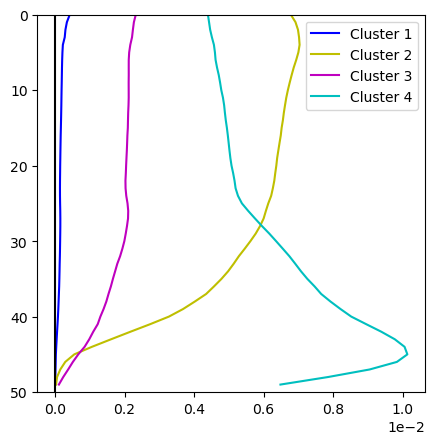

In [24]:
plt.figure(figsize=(5,5),dpi=100)
plt.plot(label1,np.arange(0,50),label='Cluster 1',c='b')
# plt.plot(label1-label1_std,np.arange(0,50),'--b')
# plt.plot(label1+label1_std,np.arange(0,50),'--b')

plt.plot(label2,np.arange(0,50),label='Cluster 2',c='y')
# plt.plot(label2-label2_std,np.arange(0,50),'--y',label='Cluster 2')
# plt.plot(label2+label2_std,np.arange(0,50),'--y',label='Cluster 2')

#plt.fill_betweenx(label2-label2_std,label2+label2_std,label='Cluster 2')
plt.plot(label3,np.arange(0,50),label='Cluster 3',c='m')
plt.plot(label4,np.arange(0,50),label='Cluster 4',c='c')
plt.plot([0,0],[0,50],'k')
#plt.gca().invert_yaxis()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim([50,0])
plt.legend()

In [177]:
print(depth)

<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)>
[9720000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 ...
    geolat_t  (yt_ocean, xt_ocean) float32 ...
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid


In [184]:
depth_coarse= depth[::10,::10]
depth_coarse.shape

land_mask = depth_coarse.fillna(1)
land_mask = land_mask.where(land_mask==1)

lon_coarse=depth_coarse.xt_ocean
lat_coarse=depth_coarse.yt_ocean
print(lat_coarse.shape,lon_coarse.shape,v_eddy_sn.shape)

(270,) (360,) (50, 270, 360)


In [187]:
labels_2D=labels.reshape(270,360)
labels_2D.shape

(270, 360)

Text(0.5, 0, 'Longitude')

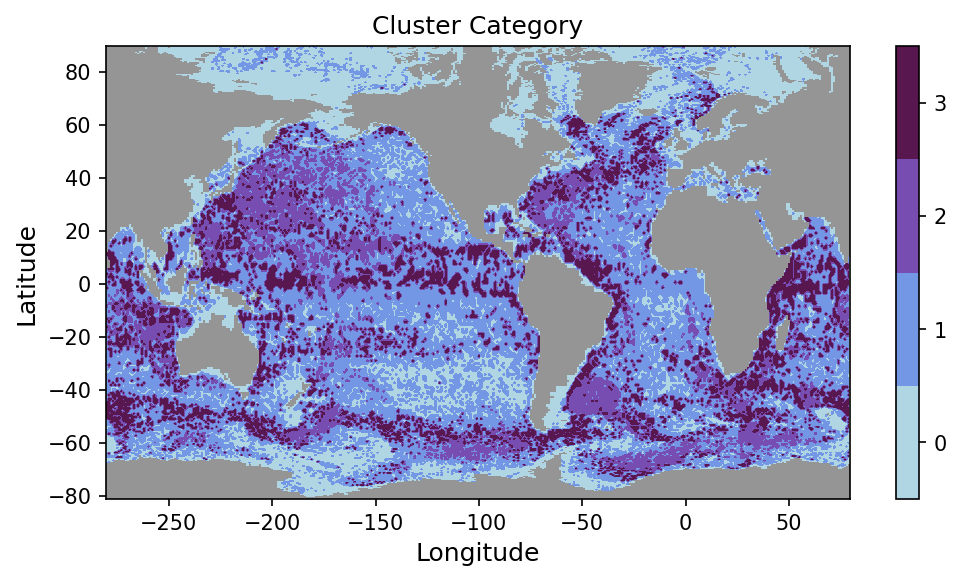

In [193]:

fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

levels=np.linspace(-.5,3.5,5)

plot1 = plt.contourf(lon_coarse,lat_coarse,labels_2D,cmap=cmocean.cm.dense,levels=levels)
land_mask.plot(vmin=0,vmax=2,cmap='Greys',add_colorbar=False)
#plt.ylim(-50,50);
plt.colorbar(ticks=[0, 1, 2, 3])

plt.title('Cluster Category',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.xlabel('Longitude',fontsize=12)
